# Data Loading

In [12]:
import os
from datetime import timedelta
import pandas as pd

###############################################################################
# 1) Setup: data_dir, data_factory
###############################################################################
# Adjust this root path as needed
# data_dir = "/home/willkewang/Datasets/GLOBEM/"
data_dir = '/Users/kwang/Data/globem'  # Example alternative path

data_factory = {
    "feature_folder": {
        "INS-W": {
            1: f"{data_dir}/INS-W_1/FeatureData/",
            2: f"{data_dir}/INS-W_2/FeatureData/",
            3: f"{data_dir}/INS-W_3/FeatureData/",
            4: f"{data_dir}/INS-W_4/FeatureData/",
        }
    },
    "survey_folder": {
        "INS-W": {
            1: f"{data_dir}/INS-W_1/SurveyData/",
            2: f"{data_dir}/INS-W_2/SurveyData/",
            3: f"{data_dir}/INS-W_3/SurveyData/",
            4: f"{data_dir}/INS-W_4/SurveyData/",
        }
    },
    "participants_info_folder": {
        "INS-W": {
            1: f"{data_dir}/INS-W_1/ParticipantsInfoData/",
            2: f"{data_dir}/INS-W_2/ParticipantsInfoData/",
            3: f"{data_dir}/INS-W_3/ParticipantsInfoData/",
            4: f"{data_dir}/INS-W_4/ParticipantsInfoData/",
        }
    },
    # If you expand beyond dep_endterm, store thresholds or file paths here:
    "threshold_book": {}
}

###############################################################################
# 2) data_loader_read_label_file (for dep_endterm only)
###############################################################################
def data_loader_read_label_file(institution: str, phase: int) -> pd.DataFrame:
    """
    Reads dep_endterm.csv for a given institution-phase. The file has columns:
      [Unnamed: 0, pid, date, BDI2, dep]
    where 'dep' is already boolean (True or False).
    
    - Drops 'Unnamed: 0' if present
    - Unifies pid format => f"{pid}#{institution}_{phase}"
    - Converts 'dep' to bool, sets 'y_raw' = dep
    - Sorts by (pid, date) and picks the LAST row per pid
    """
    csv_path = os.path.join(data_factory["survey_folder"][institution][phase], "dep_endterm.csv")
    df_label = pd.read_csv(csv_path)

    # Drop unwanted index column if present
    if "Unnamed: 0" in df_label.columns:
        df_label.drop(columns=["Unnamed: 0"], inplace=True)

    # Convert date to datetime
    df_label["date"] = pd.to_datetime(df_label["date"], errors="coerce")

    # Convert pid to standard format
    df_label["pid"] = df_label["pid"].apply(lambda x: f"{x}#{institution}_{phase}")

    # Convert dep => bool, set y_raw
    df_label["dep"] = df_label["dep"].astype(bool)
    df_label["y_raw"] = df_label["dep"]

    # Drop missing pid/dep/date rows
    df_label.dropna(subset=["pid", "dep", "date"], inplace=True)

    # Sort by pid/date, keep last
    df_label.sort_values(by=["pid", "date"], inplace=True)
    df_label = df_label.groupby("pid", as_index=False).last()

    print("Label distribution for dep_endterm:")
    print(df_label["y_raw"].value_counts(dropna=False))
    return df_label


###############################################################################
# 3) data_loader_single_dataset_label_based:
#    - Reads rapids.csv to get daily features
#    - Reads platform.csv for device_type
#    - Calls data_loader_read_label_file(...) for dep_endterm
#    - Builds a 4-week data window for each label date
###############################################################################
def data_loader_single_dataset_label_based(
    institution: str,
    phase: int,
    flag_more_feat_types: bool = False
) -> pd.DataFrame:
    """
    Loads the 4-week window of daily features (from rapids.csv) up to each label date
    in dep_endterm.csv, returning a DataFrame with columns:
      [pid, date, X_raw, y_raw, device_type].

    If 'flag_more_feat_types' is False, only keep [f_loc, f_screen, f_slp, f_steps].
    If True, also keep [f_blue, f_call].
    """
    # --- 1) Read rapids.csv as features ---
    feat_path = os.path.join(data_factory["feature_folder"][institution][phase], "rapids.csv")
    df_full_rawdata = pd.read_csv(feat_path, low_memory=False)
    df_full_rawdata["date"] = pd.to_datetime(df_full_rawdata["date"])
    df_full_rawdata["pid"] = df_full_rawdata["pid"].apply(lambda x: f"{x}#{institution}_{phase}")

    # --- 2) Read participant info (platform.csv) => device_type
    platform_path = os.path.join(data_factory["participants_info_folder"][institution][phase], "platform.csv")
    df_participant_file = pd.read_csv(platform_path, low_memory=False)
    df_participant_file["pid"] = df_participant_file["pid"].apply(lambda x: f"{x}#{institution}_{phase}")
    df_participant_file = df_participant_file.set_index("pid")

    # --- 3) Load dep_endterm label => columns [pid, date, dep, y_raw]
    df_label = data_loader_read_label_file(institution, phase)

    # --- 4) Decide which sensor columns to keep
    if not flag_more_feat_types:
        sensor_prefixes = ['f_loc', 'f_screen', 'f_slp', 'f_steps']
    else:
        sensor_prefixes = ['f_loc', 'f_screen', 'f_slp', 'f_steps', 'f_blue', 'f_call']

    retained_features = ["pid", "date"]  # always keep these
    for col in df_full_rawdata.columns:
        if any(col.startswith(ft) for ft in sensor_prefixes):
            retained_features.append(col)

    # --- 5) Build a 4-week window of data for each label date
    from datetime import timedelta

    datapoints = []
    for _, row in df_label.iterrows():
        pid = row["pid"]
        date_end = row["date"]
        date_start = date_end - timedelta(days=27)  # ~4 weeks

        # Filter raw data for that pid in [date_start, date_end]
        df_pid = df_full_rawdata[df_full_rawdata["pid"] == pid]
        df_data_window = df_pid[(df_pid["date"] >= date_start) & (df_pid["date"] <= date_end)]

        # If empty, skip
        if df_data_window.empty:
            continue

        # Ensure each day is present
        df_placeholder = pd.DataFrame({"date": pd.date_range(date_start, date_end)})
        df_placeholder["pid"] = pid
        df_data_window = pd.merge(
            df_placeholder,
            df_data_window[retained_features],
            on=["pid", "date"],
            how="left"
        )

        # device_type from platform.csv
        device_type = df_participant_file.loc[pid]["platform"].split(";")[0]

        datapoints.append({
            "pid": pid,
            "date": date_end,
            "X_raw": df_data_window[retained_features],  # 4-week daily sub-DataFrame
            "y_raw": row["y_raw"],                      # boolean label
            "device_type": device_type
        })

    df_datapoints = pd.DataFrame(datapoints)
    return df_datapoints

In [13]:
df_datapoints = data_loader_single_dataset_label_based("INS-W", 1)
print(df_datapoints.shape)

Label distribution for dep_endterm:
False    91
True     51
Name: y_raw, dtype: int64
(142, 5)


# Prepare dataset

Compute on all features

In [14]:
import pandas as pd
import numpy as np
import gc, time, warnings
from datetime import timedelta
warnings.filterwarnings("ignore")

# -------------------------------
# SETTINGS & HELPER FUNCTIONS
# -------------------------------

xu_base_features = [
    #"f_screen:phone_screen_rapids_avgdurationunlock",
    #"f_screen:phone_screen_rapids_stddurationunlock",
    "f_screen:phone_screen_rapids_countepisodeunlock",
    "f_screen:phone_screen_rapids_sumdurationunlock",
    "f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain",
    #"f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain",
    "f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain",
    #"f_slp:fitbit_sleep_intraday_rapids_ratiodurationasleepunifiedwithinmain",
    #"f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain",
    #"f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout",
    #"f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout",
    #"f_steps:fitbit_steps_intraday_rapids_countepisodesedentarybout",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps",
    #"f_loc:phone_locations_barnett_circdnrtn",
    #"f_loc:phone_locations_doryab_timeathome",
    #"f_loc:phone_locations_doryab_locationentropy",
    #"f_loc:phone_locations_doryab_loglocationvariance",
    #"f_loc:phone_locations_doryab_avglengthstayatclusters",
    #"f_loc:phone_locations_doryab_movingtostaticratio",
    #"f_loc:phone_locations_doryab_numberlocationtransitions",
    #"f_loc:phone_locations_doryab_numberofsignificantplaces",
    #"f_loc:phone_locations_doryab_outlierstimepercent",
    #"f_loc:phone_locations_doryab_radiusgyration",
    #"f_loc:phone_locations_doryab_totaldistance",
    #"f_loc:phone_locations_locmap_duration_in_locmap_study",
    #"f_loc:phone_locations_locmap_percent_in_locmap_study",
    #"f_loc:phone_locations_locmap_duration_in_locmap_exercise",
    #"f_loc:phone_locations_locmap_percent_in_locmap_exercise",
    #"f_loc:phone_locations_locmap_duration_in_locmap_greens",
    #"f_loc:phone_locations_locmap_percent_in_locmap_greens",
]

# Xu uses four time epochs.
time_epochs = ["morning", "afternoon", "evening", "night"]

# Generate the full list of discretized feature names.
# (For each base feature, we expect columns like
#  "{base_feature}_dis:{epoch}")
selected_discretized_features = [f"{feat}_dis:{epoch}" for feat in xu_base_features for epoch in time_epochs]

# A simple function to drop duplicate records for the same day from a subject’s sensor DataFrame.
def drop_duplicate_days(df_sensor):
    # Assumes df_sensor has a 'date' column (of type datetime).
    # If there are multiple records for the same day, keep the last.
    return df_sensor.drop_duplicates(subset="date", keep="last")

# A helper to build a transaction for one day.
# For each of the selected discretized feature columns,
# if a value is present, we create an item of the form "col=value".
def build_transaction(row, feature_cols):
    items = []
    for col in feature_cols:
        if col in row.index and pd.notna(row[col]):
            items.append(f"{col}={row[col]}")
    return items

# A cleanup function to clear Spark cache and force garbage collection.
def cleanup_spark(spark):
    try:
        spark.catalog.clearCache()
    except Exception as e:
        print("Error clearing Spark cache:", e)
    gc.collect()

# Assume df_datapoints is already loaded (e.g. via your data loader)
# and has at least the following columns: 'pid', 'date', and 'X_raw'.
# Here, each row in df_datapoints corresponds to one subject,
# and the "X_raw" column is a DataFrame containing that subject's time-series sensor data.

# Select 200 subjects (for example, the first 200 unique subject IDs)
all_subjects = df_datapoints["pid"].unique()
print(len(all_subjects))

# If you only want the first 160 (there are 153, so 153 will be used),
# or you can do selected_subjects = all_subjects[:153] if you want them all.
selected_subjects = all_subjects[:160]  
df_subset = df_datapoints[df_datapoints["pid"].isin(selected_subjects)].copy()
print(df_subset.shape)

# 1. Create an empty list to collect each subject's DataFrame.
list_of_dfs = []

for subject in selected_subjects:
    # Select rows for this subject.
    subject_df = df_subset[df_subset["pid"] == subject]
    if subject_df.empty:
        continue
    
    # Get the time-series DataFrame from X_raw of the *first* label date for this subject.
    df_sensor = drop_duplicate_days(subject_df.iloc[0]["X_raw"])

    # Only keep columns of interest (including date).
    df_sensor = df_sensor[["date"] + selected_discretized_features].copy()
    
    # Optionally, add pid and y_raw to keep track of each subject and their label.
    df_sensor["pid"] = subject
    df_sensor["y_raw"] = subject_df.iloc[0]["y_raw"]   # same label for all rows in df_sensor
    
    # Append this subject’s DataFrame to the list.
    list_of_dfs.append(df_sensor)

# 2. Concatenate all the collected DataFrames.
df_stacked = pd.concat(list_of_dfs, ignore_index=True)
print(df_stacked.shape)
df_stacked.head(2)

142
(142, 5)
(3976, 31)


,date,f_screen:phone_screen_rapids_countepisodeunlock_dis:morning,f_screen:phone_screen_rapids_countepisodeunlock_dis:afternoon,f_screen:phone_screen_rapids_countepisodeunlock_dis:evening,f_screen:phone_screen_rapids_countepisodeunlock_dis:night,f_screen:phone_screen_rapids_sumdurationunlock_dis:morning,f_screen:phone_screen_rapids_sumdurationunlock_dis:afternoon,f_screen:phone_screen_rapids_sumdurationunlock_dis:evening,f_screen:phone_screen_rapids_sumdurationunlock_dis:night,f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_dis:morning,...,f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_dis:morning,f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_dis:afternoon,f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_dis:evening,f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_dis:night,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:morning,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:afternoon,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:evening,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:night,pid,y_raw
0,2018-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,m,l,l,h,m,m,m,l,INS-W_001#INS-W_1,False
1,2018-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,l,...,l,h,l,h,m,m,h,l,INS-W_001#INS-W_1,False


# Spark execution

Adding weekday vs weekend slices:

In [20]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
import json

##################################
# 2. Create SparkSession
##################################
# spark = SparkSession.builder \
#     .appName("SparkFPGrowthExample") \
#     .master("local[*]") \
#     .getOrCreate()

spark = (
    SparkSession.builder
    .appName("FPGrowthAssociationRules")
    .config("spark.driver.memory", "16g")   # or more, e.g. "16g"
    .config("spark.executor.memory", "16g") # if relevant
    .config("spark.driver.maxResultSize", "0")  # unlimited
    .getOrCreate()
)

# Suppose df_stacked has columns:
#   - date (pd.Timestamp)
#   - pid
#   - f_screen:phone_screen_rapids_avgdurationunlock_dis:morning
#   - f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_dis:morning
#   - ...
#   - f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:night
# and so on, for both weekdays and weekends.

slices = {
    "wkdy_morning": {"dayofweek": range(0,5), "epoch": "morning"},
    "wkdy_afternoon": {"dayofweek": range(0,5), "epoch": "afternoon"},
    "wkdy_evening": {"dayofweek": range(0,5), "epoch": "evening"},
    "wkdy_night": {"dayofweek": range(0,5), "epoch": "night"},
    "wkend_morning": {"dayofweek": range(5,7), "epoch": "morning"},
    "wkend_afternoon": {"dayofweek": range(5,7), "epoch": "afternoon"},
    "wkend_evening": {"dayofweek": range(5,7), "epoch": "evening"},
    "wkend_night": {"dayofweek": range(5,7), "epoch": "night"},
}

############################################################
# 2) Integer-Encoding Items
############################################################
def build_item_mapping(df_stacked, discretized_cols):
    """
    Scan all discretized columns, gather unique string 'col=value',
    and assign an integer ID to each.
    Returns a dict mapping 'col=value' -> integerID (item2id),
    plus the inverse mapping integerID -> 'col=value' (id2item).
    """
    item_set = set()

    # Collect all unique 'col=value' pairs found in df_stacked (for all rows).
    for col in discretized_cols:
        unique_vals = df_stacked[col].dropna().unique()
        for val in unique_vals:
            item_str = f"{col}={val}"
            item_set.add(item_str)

    # Now assign an integer ID. We'll just enumerate them.
    item2id = {}
    id2item = {}
    for idx, item_str in enumerate(sorted(item_set), start=1):
        item2id[item_str] = idx
        id2item[idx] = item_str

    id2item_strkeys = {str(k): v for k, v in id2item.items()}

    mapping_dict = {
        "item2id": item2id,
        "id2item": id2item_strkeys
    }

    # Write to JSON
    with open("item_mapping.json", "w") as f:
        json.dump(mapping_dict, f, indent=2)
    print("Saved item mappings to item_mapping.json")

    return item2id, id2item


def build_transaction_int(row, feature_cols, item2id):
    """
    Convert discretized columns from row into a list of integer-encoded items.
    E.g., if row['f_screen_dis:morning'] == 'low', then item is "f_screen_dis:morning=low".
    If item2id says that's 123, we add 123 to the transaction.
    """
    items_int = []
    for col in feature_cols:
        val = row[col]
        if pd.notna(val):
            item_str = f"{col}={val}"
            if item_str in item2id:
                items_int.append(item2id[item_str])
    return items_int

############################################################
# 3) Prepare the Master Mapping + Helper Lists
############################################################
# Identify which columns in df_stacked are your "discretized features."
# For example, all columns that contain "_dis:" might be your discretized columns.
discretized_cols = selected_discretized_features

# Build the mapping for all possible "column=value" pairs.
item2id, id2item = build_item_mapping(df_stacked, discretized_cols)
print(f"Total unique discrete items: {len(item2id)}")

############################################################
# 4) Run Spark FPGrowth Per Slice
############################################################
# Let’s define the Spark session once, then re-use it for each slice.
spark = SparkSession.builder \
    .appName("SparkFPGrowth_xuStyle") \
    .master("local[*]") \
    .getOrCreate()

# We'll store results in a dictionary keyed by slice name.
all_rules_dfs = {}  # each entry is a Pandas DataFrame of association rules
all_freq_itemsets_dfs = {}

# Xu’s same thresholds. (Adjust if you prefer.)
# Example: 30% support, 70% confidence.
min_support = 0.3
min_confidence = 0.7

for slice_key, slice_info in slices.items():
    dayofweek_range = slice_info["dayofweek"]  # e.g. range(0,5) for M-F
    epoch = slice_info["epoch"]               # "morning", etc.

    # Filter df_stacked to just the desired day-of-week + epoch
    # We'll check if the column name contains the epoch, or if we just want
    # to gather columns that are relevant. 

    df_slice = df_stacked[
        df_stacked["date"].dt.dayofweek.isin(dayofweek_range)
    ].copy()

    relevant_cols = [c for c in discretized_cols if epoch in c]

    # Build transactions as lists of integers
    transactions_int = []
    for i, row in df_slice.iterrows():
        tx = build_transaction_int(row, relevant_cols, item2id)
        if len(tx) > 1:
            transactions_int.append((i, tx))  # (transactionID, items)

    if not transactions_int:
        print(f"No transactions for slice {slice_key}, skipping.")
        continue

    # Create Spark DataFrame with columns: "id" and "items"
    df_transactions = spark.createDataFrame(
        transactions_int, ["id", "items"]
    )

    print(f"\n--- Slice: {slice_key} ---")
    print("Num transactions:", df_transactions.count())

    # Run FPGrowth
    fpGrowth = FPGrowth(
        itemsCol="items",
        minSupport=min_support,
        minConfidence=min_confidence
    )
    model = fpGrowth.fit(df_transactions)

    # Collect frequent itemsets
    freq_itemsets_spark = model.freqItemsets
    freq_itemsets_pd = freq_itemsets_spark.toPandas()
    # Convert item IDs back to strings
    freq_itemsets_pd["items_str"] = freq_itemsets_pd["items"].apply(
        lambda ids: [id2item[item_id] for item_id in ids]
    )
    all_freq_itemsets_dfs[slice_key] = freq_itemsets_pd

    ##################################
    # Convert IDs back to strings
    ##################################
    rules_spark = model.associationRules
    rules_pd = rules_spark.toPandas()

    rules_pd["antecedent_str"] = rules_pd["antecedent"].apply(
        lambda ids: [id2item[item_id] for item_id in ids]
    )
    rules_pd["consequent_str"] = rules_pd["consequent"].apply(
        lambda ids: [id2item[item_id] for item_id in ids]
    )

    ##################################
    # Sort by confidence (descending)
    ##################################
    rules_pd = rules_pd.sort_values("confidence", ascending=False)

    ##################################
    # Print only the top 2 rules
    ##################################
    print("\nTop 2 Rules by Confidence:")
    for idx, row in rules_pd.head(2).iterrows():
        print(f"\n---- Rule {idx} ----")
        row_dict = row.to_dict()
        for k, v in row_dict.items():
            print(f"{k}: {v}")
        print("####################################################")

##################################
# 5. Extract Frequent Itemsets
##################################
freq_itemsets = model.freqItemsets  # This is a Spark DataFrame
freq_itemsets_pandas = freq_itemsets.toPandas()  # Convert to Pandas
print("\nFrequent Itemsets:")
print(freq_itemsets_pandas)

##################################
# Extract Association Rules
##################################
rules = model.associationRules  # Spark DataFrame
rules_pandas = rules.toPandas() # Convert to Pandas
print("\nAssociation Rules:")
print(rules_pandas)

##################################
# (Optional) Filter or Sort Rules
##################################
# Example filter: keep rules with confidence >= 0.5 and lift > 2
filtered_rules = rules_pandas[
    (rules_pandas["confidence"] >= 0.5) & 
    (rules_pandas["lift"] > 2)
]
print("\nFiltered Rules (conf >= 0.5, lift > 2):")
print(filtered_rules)

##################################
# Stop Spark
##################################
spark.stop()


Saved item mappings to item_mapping.json
Total unique discrete items: 358


25/04/02 14:35:14 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.



--- Slice: wkdy_morning ---
Num transactions: 2811

Top 2 Rules by Confidence:

---- Rule 15672 ----
antecedent: [163, 129, 141, 85, 153]
consequent: [21]
confidence: 1.0
lift: 1.0655799848369978
support: 0.40732835289932406
antecedent_str: ['f_loc:phone_locations_locmap_percent_in_locmap_greens_dis:morning=m', 'f_loc:phone_locations_locmap_duration_in_locmap_greens_dis:morning=m', 'f_loc:phone_locations_locmap_duration_in_locmap_study_dis:morning=m', 'f_loc:phone_locations_doryab_radiusgyration_dis:morning=m', 'f_loc:phone_locations_locmap_percent_in_locmap_exercise_dis:morning=m']
consequent_str: ['f_loc:phone_locations_doryab_locationentropy_dis:morning=m']
####################################################

---- Rule 8775 ----
antecedent: [141, 65, 75, 119]
consequent: [55]
confidence: 1.0
lift: 1.0667931688804553
support: 0.5734614016364283
antecedent_str: ['f_loc:phone_locations_locmap_duration_in_locmap_study_dis:morning=m', 'f_loc:phone_locations_doryab_numberofsignificantpl

In [21]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
import json
import pandas as pd

spark = (
    SparkSession.builder
    .appName("FPGrowthAssociationRules")
    .config("spark.driver.memory", "16g")
    .config("spark.executor.memory", "16g")
    .config("spark.driver.maxResultSize", "0")  # unlimited
    .getOrCreate()
)

# Define slices as before
slices = {
    "wkdy_morning": {"dayofweek": range(0,5), "epoch": "morning"},
    "wkdy_afternoon": {"dayofweek": range(0,5), "epoch": "afternoon"},
    "wkdy_evening": {"dayofweek": range(0,5), "epoch": "evening"},
    "wkdy_night": {"dayofweek": range(0,5), "epoch": "night"},
    "wkend_morning": {"dayofweek": range(5,7), "epoch": "morning"},
    "wkend_afternoon": {"dayofweek": range(5,7), "epoch": "afternoon"},
    "wkend_evening": {"dayofweek": range(5,7), "epoch": "evening"},
    "wkend_night": {"dayofweek": range(5,7), "epoch": "night"},
}

def build_item_mapping(df_stacked, discretized_cols):
    item_set = set()
    for col in discretized_cols:
        unique_vals = df_stacked[col].dropna().unique()
        for val in unique_vals:
            item_str = f"{col}={val}"
            item_set.add(item_str)

    item2id = {}
    id2item = {}
    for idx, item_str in enumerate(sorted(item_set), start=1):
        item2id[item_str] = idx
        id2item[idx] = item_str

    # Optional: save to JSON
    id2item_strkeys = {str(k): v for k, v in id2item.items()}
    mapping_dict = {
        "item2id": item2id,
        "id2item": id2item_strkeys
    }
    with open("item_mapping.json", "w") as f:
        json.dump(mapping_dict, f, indent=2)
    print("Saved item mappings to item_mapping.json")

    return item2id, id2item

def build_transaction_int(row, feature_cols, item2id):
    items_int = []
    for col in feature_cols:
        val = row[col]
        if pd.notna(val):
            item_str = f"{col}={val}"
            if item_str in item2id:
                items_int.append(item2id[item_str])
    return items_int

# Suppose df_stacked and selected_discretized_features are defined
discretized_cols = selected_discretized_features

item2id, id2item = build_item_mapping(df_stacked, discretized_cols)
print(f"Total unique discrete items: {len(item2id)}")

# We'll keep track of rules/freq itemsets for each slice
all_rules_dfs = {}
all_freq_itemsets_dfs = {}

# Set thresholds
min_support = 0.5
min_confidence = 0.8

for slice_key, slice_info in slices.items():
    dayofweek_range = slice_info["dayofweek"]
    epoch = slice_info["epoch"]

    # Filter rows for the slice
    df_slice = df_stacked[
        df_stacked["date"].dt.dayofweek.isin(dayofweek_range)
    ].copy()

    relevant_cols = [c for c in discretized_cols if epoch in c]

    # Build transactions
    transactions_int = []
    for i, row in df_slice.iterrows():
        tx = build_transaction_int(row, relevant_cols, item2id)
        if len(tx) > 1:
            transactions_int.append((i, tx))

    if not transactions_int:
        print(f"No transactions for slice {slice_key}, skipping.")
        continue

    df_transactions = spark.createDataFrame(transactions_int, ["id", "items"])
    print(f"\n--- Slice: {slice_key} ---")
    print("Num transactions:", df_transactions.count())

    # Run FPGrowth
    fpGrowth = FPGrowth(
        itemsCol="items",
        minSupport=min_support,
        minConfidence=min_confidence
    )
    model = fpGrowth.fit(df_transactions)

    # Collect frequent itemsets
    freq_itemsets_spark = model.freqItemsets
    freq_itemsets_pd = freq_itemsets_spark.toPandas()
    freq_itemsets_pd["items_str"] = freq_itemsets_pd["items"].apply(
        lambda ids: [id2item[item_id] for item_id in ids]
    )
    all_freq_itemsets_dfs[slice_key] = freq_itemsets_pd

    # Collect association rules
    rules_spark = model.associationRules
    rules_pd = rules_spark.toPandas()

    rules_pd["antecedent_str"] = rules_pd["antecedent"].apply(
        lambda ids: [id2item[item_id] for item_id in ids]
    )
    rules_pd["consequent_str"] = rules_pd["consequent"].apply(
        lambda ids: [id2item[item_id] for item_id in ids]
    )

    # Sort by confidence and keep for final summary
    rules_pd.sort_values("confidence", ascending=False, inplace=True)
    all_rules_dfs[slice_key] = rules_pd

    # Print top 2 rules
    print("\nTop 2 Rules by Confidence:")
    for idx, row in rules_pd.head(2).iterrows():
        print(f"\n---- Rule {idx} ----")
        for k, v in row.to_dict().items():
            print(f"{k}: {v}")
        print("####################################################")

##################################
# Stop Spark
##################################
spark.stop()


Saved item mappings to item_mapping.json
Total unique discrete items: 358

--- Slice: wkdy_morning ---
Num transactions: 2811

Top 2 Rules by Confidence:

---- Rule 1638 ----
antecedent: [163, 85, 75, 119]
consequent: [153]
confidence: 1.0
lift: 1.0516273849607183
support: 0.5062255425115617
antecedent_str: ['f_loc:phone_locations_locmap_percent_in_locmap_greens_dis:morning=m', 'f_loc:phone_locations_doryab_radiusgyration_dis:morning=m', 'f_loc:phone_locations_doryab_outlierstimepercent_dis:morning=m', 'f_loc:phone_locations_locmap_duration_in_locmap_exercise_dis:morning=m']
consequent_str: ['f_loc:phone_locations_locmap_percent_in_locmap_exercise_dis:morning=m']
####################################################

---- Rule 1971 ----
antecedent: [141, 85, 55, 75]
consequent: [119]
confidence: 1.0
lift: 1.0520209580838324
support: 0.5638562789043046
antecedent_str: ['f_loc:phone_locations_locmap_duration_in_locmap_study_dis:morning=m', 'f_loc:phone_locations_doryab_radiusgyration_dis:

In [22]:
# After finishing all slices, we can see how many rules each slice has
print("\n=== Summary of Rules per Slice ===")
for slice_key, df_rules in all_rules_dfs.items():
    print(f"{slice_key}: {len(df_rules)} rules found")


=== Summary of Rules per Slice ===
wkdy_morning: 3277 rules found
wkdy_afternoon: 378 rules found
wkdy_evening: 9646 rules found
wkdy_night: 11253 rules found
wkend_morning: 2041 rules found
wkend_afternoon: 435 rules found
wkend_evening: 7187 rules found
wkend_night: 11253 rules found


# Compare depressed vs non-depressed people

In [42]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth
import json
import pandas as pd

##################################
# 1. Spark Session
##################################
spark = (
    SparkSession.builder
    .appName("FPGrowth_Compare_Depressed")
    .config("spark.driver.memory", "16g")
    .config("spark.executor.memory", "16g")
    .config("spark.driver.maxResultSize", "0")
    .getOrCreate()
)

##################################
# 2. Slices
##################################
slices = {
    "wkdy_morning":   {"dayofweek": range(0,5), "epoch": "morning"},
    "wkdy_afternoon": {"dayofweek": range(0,5), "epoch": "afternoon"},
    "wkdy_evening":   {"dayofweek": range(0,5), "epoch": "evening"},
    "wkdy_night":     {"dayofweek": range(0,5), "epoch": "night"},
    "wkend_morning":  {"dayofweek": range(5,7), "epoch": "morning"},
    "wkend_afternoon":{"dayofweek": range(5,7), "epoch": "afternoon"},
    "wkend_evening":  {"dayofweek": range(5,7), "epoch": "evening"},
    "wkend_night":    {"dayofweek": range(5,7), "epoch": "night"},
}

##################################
# 3. Helper functions
##################################
def build_item_mapping(df_stacked, discretized_cols):
    item_set = set()
    for col in discretized_cols:
        unique_vals = df_stacked[col].dropna().unique()
        for val in unique_vals:
            item_str = f"{col}={val}"
            item_set.add(item_str)

    item2id = {}
    id2item = {}
    for idx, item_str in enumerate(sorted(item_set), start=1):
        item2id[item_str] = idx
        id2item[idx] = item_str

    return item2id, id2item

def build_transaction_int(row, feature_cols, item2id):
    items_int = []
    for col in feature_cols:
        val = row[col]
        if pd.notna(val):
            item_str = f"{col}={val}"
            if item_str in item2id:
                items_int.append(item2id[item_str])
    return items_int

def run_fpgrowth_by_slice(df_group, discretized_cols, item2id, id2item,
                          slices_dict, min_support=0.3, min_confidence=0.7):
    """
    For each slice in slices_dict, run FPGrowth on df_group, returning a dict
    of { slice_key: rules_df }.
    """
    rules_dict = {}

    for slice_key, info in slices_dict.items():
        dayofweek_range = info["dayofweek"]
        epoch = info["epoch"]

        df_slice = df_group[
            df_group["date"].dt.dayofweek.isin(dayofweek_range)
        ].copy()

        # For that epoch, choose columns
        relevant_cols = [c for c in discretized_cols if epoch in c]

        # Build transactions
        transactions_int = []
        for i, row in df_slice.iterrows():
            tx = build_transaction_int(row, relevant_cols, item2id)
            if len(tx) > 1:
                transactions_int.append((i, tx))

        if not transactions_int:
            print(f"No transactions for slice {slice_key} (in this group).")
            continue

        df_transactions = spark.createDataFrame(transactions_int, ["id","items"])
        fpGrowth = FPGrowth(itemsCol="items", minSupport=min_support, minConfidence=min_confidence)
        model = fpGrowth.fit(df_transactions)

        # Convert the associationRules to Pandas
        rules_pd = model.associationRules.toPandas()

        # Convert item IDs back to strings
        rules_pd["antecedent_str"] = rules_pd["antecedent"].apply(
            lambda arr: [id2item[x] for x in arr]
        )
        rules_pd["consequent_str"] = rules_pd["consequent"].apply(
            lambda arr: [id2item[x] for x in arr]
        )

        rules_pd["slice"] = slice_key
        rules_pd = rules_pd.sort_values("confidence", ascending=False)

        rules_dict[slice_key] = rules_pd

        print(f"[Group] Slice {slice_key}: Found {len(rules_pd)} rules")

    return rules_dict

##################################
# 4. Suppose you've prepared df_stacked
##################################
# - Must have: "y_raw" label (True/False)
# - Must have: columns in selected_discretized_features
# - Must have: "date" (datetime)

# Example split:
df_depressed = df_stacked[df_stacked["y_raw"] == True].copy()
df_nondep    = df_stacked[df_stacked["y_raw"] == False].copy()

print("Depressed subjects:", df_depressed["pid"].nunique())
print("Non-depressed subjects:", df_nondep["pid"].nunique())

# Build item mappings:
discretized_cols = selected_discretized_features
item2id, id2item = build_item_mapping(df_stacked, discretized_cols)
print("Total unique items in entire dataset:", len(item2id))

##################################
# 5. Run FPGrowth on each group
##################################
rules_depressed = run_fpgrowth_by_slice(
    df_group=df_depressed,
    discretized_cols=discretized_cols,
    item2id=item2id,
    id2item=id2item,
    slices_dict=slices,
    min_support=0.1,
    min_confidence=0.3
)
rules_nondep = run_fpgrowth_by_slice(
    df_group=df_nondep,
    discretized_cols=discretized_cols,
    item2id=item2id,
    id2item=id2item,
    slices_dict=slices,
    min_support=0.1,
    min_confidence=0.3
)

##################################
# 6. Compare/Contrast the two sets of rules
##################################
# We'll build a single DataFrame combining them,
# keyed by the same antecedent & consequent. For example:

def make_rule_key(row):
    # canonical string for matching
    ant = ";".join(sorted(row["antecedent_str"]))
    con = ";".join(sorted(row["consequent_str"]))
    return f"{ant} => {con}"

def gather_rules_dict(rules_dict, label_name):
    """
    Convert a dict of slice->rules_df into one big DataFrame
    with columns slice, rule_key, support, confidence, lift, label_group.
    """
    frames = []
    for slice_key, df_r in rules_dict.items():
        df_temp = df_r.copy()
        df_temp["rule_key"] = df_temp.apply(make_rule_key, axis=1)
        df_temp["label_group"] = label_name
        frames.append(df_temp[["slice","rule_key","support","confidence","lift","label_group"]])
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

df_rules_depressed = gather_rules_dict(rules_depressed, label_name="depressed")
df_rules_nondep    = gather_rules_dict(rules_nondep,    label_name="nondep")

# Merge them
all_rules = pd.merge(
    df_rules_depressed,
    df_rules_nondep,
    how="outer",
    on=["slice","rule_key"],
    suffixes=("_dep","_nondep")
).fillna(0)

# so we have columns:
#   slice
#   rule_key
#   support_dep
#   confidence_dep
#   lift_dep
#   label_group_dep  # or 0 if absent
#   support_nondep
#   confidence_nondep
#   lift_nondep
#   label_group_nondep  # or 0 if absent

# We can compute differences:
all_rules["conf_diff"] = all_rules["confidence_dep"] - all_rules["confidence_nondep"]
all_rules["supp_diff"] = all_rules["support_dep"]    - all_rules["support_nondep"]
all_rules["lift_diff"] = all_rules["lift_dep"]       - all_rules["lift_nondep"]

##################################
# 7. Identify "depressed-only" rules
##################################
# i.e., those that appear in depressed group but not in non-dep
depressed_only = all_rules[
    (all_rules["support_dep"] > 0) &
    (all_rules["support_nondep"] == 0)
]

print("\n--- Depressed-Only Rules ---")
print(depressed_only[["slice","rule_key","support_dep","confidence_dep","lift_dep"]])

##################################
# 8. Stop Spark
##################################
spark.stop()


Depressed subjects: 51
Non-depressed subjects: 91
Total unique items in entire dataset: 84
[Group] Slice wkdy_morning: Found 55 rules
[Group] Slice wkdy_afternoon: Found 33 rules
[Group] Slice wkdy_evening: Found 33 rules
[Group] Slice wkdy_night: Found 35 rules
[Group] Slice wkend_morning: Found 158 rules
[Group] Slice wkend_afternoon: Found 59 rules
[Group] Slice wkend_evening: Found 48 rules
[Group] Slice wkend_night: Found 69 rules
[Group] Slice wkdy_morning: Found 52 rules
[Group] Slice wkdy_afternoon: Found 26 rules
[Group] Slice wkdy_evening: Found 33 rules
[Group] Slice wkdy_night: Found 26 rules
[Group] Slice wkend_morning: Found 117 rules
[Group] Slice wkend_afternoon: Found 49 rules
[Group] Slice wkend_evening: Found 39 rules
[Group] Slice wkend_night: Found 67 rules

--- Depressed-Only Rules ---
            slice                                           rule_key  \
31   wkdy_morning  f_slp:fitbit_sleep_intraday_rapids_maxduration...   
41   wkdy_morning  f_steps:fitbit_ste

In [41]:
for idx, row in depressed_only.iterrows():
    print(f"Row {idx}: {row['rule_key']}")

Row 7: f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_dis:morning=m => f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:morning=m
Row 12: f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_dis:morning=l => f_screen:phone_screen_rapids_countepisodeunlock_dis:morning=h
Row 13: f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:morning=m => f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_dis:morning=m
Row 21: f_screen:phone_screen_rapids_countepisodeunlock_dis:morning=h => f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_dis:morning=l
Row 29: f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_dis:afternoon=m => f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:afternoon=m
Row 31: f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:afternoon=m => f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_dis:afternoon=m
Row 50: f_screen:phone_screen_rapids_countepisodeunlock_dis:evening=m => f_screen:phone_screen_rapids_sumdurationunlock

In [46]:
import re

unique_consequents = set()

for rule_str in depressed_only["rule_key"]:
    # 1) Separate LHS and RHS on " => "
    parts = rule_str.split("=>")
    if len(parts) != 2:
        # If it doesn't split nicely, skip or handle differently
        continue

    # 2) The RHS is parts[1]. Split by '&' if multiple
    rhs = parts[1].strip()  # e.g. "label_C & label_D"
    rhs_items = rhs.split("&")

    # 3) Collect each RHS item, removing trailing "=l", "=m", or "=h"
    for item in rhs_items:
        item_clean = item.strip()
        # remove any trailing =l, =m, or =h using a regex
        item_clean = re.sub(r"=(l|m|h)$", "", item_clean)
        unique_consequents.add(item_clean)

# Convert set -> list if you prefer a list
unique_consequents_list = sorted(unique_consequents)
print("Unique consequents:")
for c in unique_consequents_list:
    print(c)

Unique consequents:
f_screen:phone_screen_rapids_countepisodeunlock_dis:afternoon
f_screen:phone_screen_rapids_countepisodeunlock_dis:evening
f_screen:phone_screen_rapids_countepisodeunlock_dis:morning
f_screen:phone_screen_rapids_countepisodeunlock_dis:night
f_screen:phone_screen_rapids_sumdurationunlock_dis:afternoon
f_screen:phone_screen_rapids_sumdurationunlock_dis:evening
f_screen:phone_screen_rapids_sumdurationunlock_dis:morning
f_screen:phone_screen_rapids_sumdurationunlock_dis:night
f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_dis:morning
f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_dis:night
f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_dis:morning
f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_dis:night
f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_dis:afternoon
f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_dis:evening
f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_d

In [24]:
important_features = [
    "f_screen:phone_screen_rapids_countepisodeunlock:afternoon",
    "f_screen:phone_screen_rapids_countepisodeunlock:evening",
    "f_screen:phone_screen_rapids_countepisodeunlock:morning",
    "f_screen:phone_screen_rapids_countepisodeunlock:night",
    "f_screen:phone_screen_rapids_sumdurationunlock:afternoon",
    "f_screen:phone_screen_rapids_sumdurationunlock:evening",
    "f_screen:phone_screen_rapids_sumdurationunlock:morning",
    "f_screen:phone_screen_rapids_sumdurationunlock:night",
    "f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain:morning",
    "f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain:night",
    "f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain:morning",
    "f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain:night",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout:afternoon",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout:evening",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout:morning",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout:night",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout:afternoon",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout:evening",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout:morning",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout:night",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:afternoon",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:evening",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:morning",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps:night",
]

list_of_dfs = []
all_subjects = df_datapoints["pid"].unique()

for subject in all_subjects:
    subject_df = df_datapoints[df_datapoints["pid"] == subject]
    if subject_df.empty:
        continue
    
    # X_raw is the day-level DataFrame for this subject
    df_sensor = subject_df.iloc[0]["X_raw"]
    if df_sensor is None or df_sensor.empty:
        continue

    # Drop duplicates by day (if needed)
    df_sensor = df_sensor.drop_duplicates(subset="date", keep="last")

    # Keep only your important columns plus "date" if they exist
    keep_cols = ["date"] + [c for c in important_features if c in df_sensor.columns]
    df_sensor = df_sensor[keep_cols].copy()

    # Add pid, y_raw
    df_sensor["pid"] = subject
    df_sensor["y_raw"] = subject_df.iloc[0]["y_raw"]

    list_of_dfs.append(df_sensor)

df_stacked = pd.concat(list_of_dfs, ignore_index=True)
print(df_stacked.shape)
df_stacked.head()

df_stacked["date"] = pd.to_datetime(df_stacked["date"]).dt.floor("D")
df_stacked = df_stacked.sort_values(["pid","date"], ascending=[True,True]).reset_index(drop=True)

NUM_DAYS = 28
subject_matrices = {}
subject_labels = {}

for pid, grp in df_stacked.groupby("pid"):
    df_28 = grp.tail(NUM_DAYS)
    # We only want the important features in the final matrix
    # (already removed all other columns, but let's reindex to be safe)
    df_28 = df_28.reindex(columns=["pid","date","y_raw"] + important_features, fill_value=np.nan)

    # Convert only the features to a NumPy array
    arr_28 = df_28[important_features].to_numpy(dtype=float)

    # If fewer than 28 days, pad
    nrows, ncols = arr_28.shape
    if nrows < NUM_DAYS:
        pad_rows = NUM_DAYS - nrows
        pad_arr = np.full((pad_rows, ncols), np.nan)
        arr_28 = np.vstack([pad_arr, arr_28])

    subject_matrices[pid] = arr_28
    subject_labels[pid] = grp["y_raw"].iloc[0]

print("Number of subjects:", len(subject_matrices))
one_pid = list(subject_matrices.keys())[0]
print("Example subject:", one_pid)
print("Matrix shape:", subject_matrices[one_pid].shape)
print("Label:", subject_labels[one_pid])


(3976, 27)
Number of subjects: 142
Example subject: INS-W_001#INS-W_1
Matrix shape: (28, 24)
Label: False


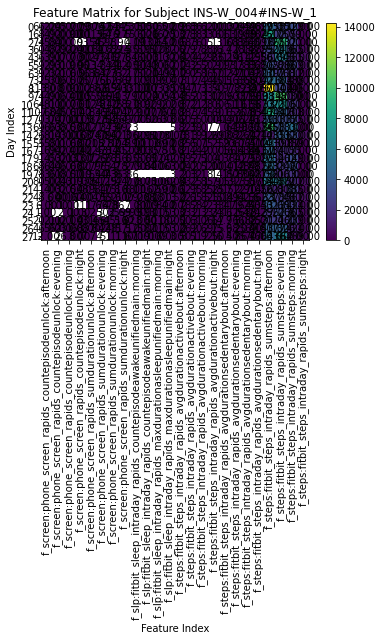

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_subject_matrix_with_values(pid, subject_matrices, feature_names=None):
    """
    Display a 2D heatmap for the given subject's (28 x #features) matrix,
    with numeric values in each cell.
    
    Rows = days, Columns = features.

    Args:
        pid: The subject ID to visualize.
        subject_matrices: dict of {pid: numpy array} where each array is (28 x n_features).
        feature_names: optional list of feature column names (for labeling x-axis).
    """
    if pid not in subject_matrices:
        print(f"PID {pid} not found in subject_matrices.")
        return
    
    mat = subject_matrices[pid]
    n_days, n_feats = mat.shape

    fig, ax = plt.subplots()
    cax = ax.imshow(mat, aspect="auto", interpolation="nearest")
    fig.colorbar(cax)

    # Optional labeling of the x-axis with feature names
    if feature_names and len(feature_names) == n_feats:
        ax.set_xticks(np.arange(n_feats))
        ax.set_xticklabels(feature_names, rotation=90)
    else:
        ax.set_xticks(np.arange(n_feats))
        ax.set_xticklabels([f"F{j}" for j in range(n_feats)], rotation=90)

    # Label y-axis with day indices
    ax.set_yticks(np.arange(n_days))
    ax.set_yticklabels(np.arange(n_days))
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Day Index")
    ax.set_title(f"Feature Matrix for Subject {pid}")

    # Annotate each cell with its numeric value
    for i in range(n_days):
        for j in range(n_feats):
            val = mat[i, j]
            if not np.isnan(val):
                # Format to 2 decimals, or adjust as desired
                ax.text(j, i, f"{val:.2f}", ha="center", va="center")

    plt.tight_layout()
    plt.show()


# Example usage:
pid_example = list(subject_matrices.keys())[3]
visualize_subject_matrix_with_values(pid_example, subject_matrices, feature_names=important_features)


## Spark clean up

In [15]:
import pandas as pd
import numpy as np
import gc, time, warnings
from datetime import timedelta
warnings.filterwarnings("ignore")

# Xu’s base features (raw)
xu_base_features = [
    "f_screen:phone_screen_rapids_countepisodeunlock",
    "f_screen:phone_screen_rapids_sumdurationunlock",
    "f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain",
    "f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps",
]
time_epochs = ["morning", "afternoon", "evening", "night"]

# Now build the raw feature column names
selected_raw_features = [
    f"{feat}_{epoch}" for feat in xu_base_features for epoch in time_epochs
]

def drop_duplicate_days(df_sensor):
    return df_sensor.drop_duplicates(subset="date", keep="last")

def build_transaction(row, feature_cols):
    items = []
    for col in feature_cols:
        if col in row and pd.notna(row[col]):
            items.append(f"{col}={row[col]}")
    return items

def cleanup_spark(spark):
    try:
        spark.catalog.clearCache()
    except Exception as e:
        print("Error clearing Spark cache:", e)
    gc.collect()

# Suppose df_datapoints has columns: ["pid", "date", "y_raw", "X_raw"] 
all_subjects = df_datapoints["pid"].unique()
selected_subjects = all_subjects[:160]
df_subset = df_datapoints[df_datapoints["pid"].isin(selected_subjects)].copy()

list_of_dfs = []

for subject in selected_subjects:
    subject_df = df_subset[df_subset["pid"] == subject]
    if subject_df.empty:
        continue

    # Drop duplicates in the subject's X_raw, keep only 'date' + RAW columns
    df_sensor = drop_duplicate_days(subject_df.iloc[0]["X_raw"])
    df_sensor = df_sensor[["date"] + selected_raw_features].copy()

    df_sensor["pid"] = subject
    df_sensor["y_raw"] = subject_df.iloc[0]["y_raw"]  # same label for entire subject

    list_of_dfs.append(df_sensor)

df_stacked = pd.concat(list_of_dfs, ignore_index=True)
print(df_stacked.shape)
df_stacked.head()


KeyError: "['f_screen:phone_screen_rapids_countepisodeunlock_morning', 'f_screen:phone_screen_rapids_countepisodeunlock_afternoon', 'f_screen:phone_screen_rapids_countepisodeunlock_evening', 'f_screen:phone_screen_rapids_countepisodeunlock_night', 'f_screen:phone_screen_rapids_sumdurationunlock_morning', 'f_screen:phone_screen_rapids_sumdurationunlock_afternoon', 'f_screen:phone_screen_rapids_sumdurationunlock_evening', 'f_screen:phone_screen_rapids_sumdurationunlock_night', 'f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_morning', 'f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_afternoon', 'f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_evening', 'f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_night', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_morning', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_afternoon', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_evening', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_night', 'f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_morning', 'f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_afternoon', 'f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_evening', 'f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout_night', 'f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_morning', 'f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_afternoon', 'f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_evening', 'f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_night', 'f_steps:fitbit_steps_intraday_rapids_sumsteps_morning', 'f_steps:fitbit_steps_intraday_rapids_sumsteps_afternoon', 'f_steps:fitbit_steps_intraday_rapids_sumsteps_evening', 'f_steps:fitbit_steps_intraday_rapids_sumsteps_night'] not in index"

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

# Initialize a local SparkSession
spark = SparkSession.builder \
    .appName("ARMExample") \
    .master("local[*]") \
    .getOrCreate()

spark.stop()

import gc
gc.collect()

import os
import shutil

# You may need to adjust this path if you have a custom setting.
spark_temp_dir = "/tmp"

# List all items in the temporary directory
for item in os.listdir(spark_temp_dir):
    # Check if the item starts with 'spark-' (typical prefix for Spark temp directories)
    if item.startswith("spark-"):
        full_path = os.path.join(spark_temp_dir, item)
        try:
            shutil.rmtree(full_path)
            print(f"Removed temporary folder: {full_path}")
        except Exception as e:
            print(f"Could not remove {full_path}: {e}")

178

# Matrix Generation

In [30]:
base_features = [
    "f_screen:phone_screen_rapids_countepisodeunlock",
    "f_screen:phone_screen_rapids_sumdurationunlock",
    "f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain",
    "f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationactivebout",
    "f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout",
    "f_steps:fitbit_steps_intraday_rapids_sumsteps"
    ]
time_epochs = ["morning", "afternoon", "evening", "night"]

# Build the final column list, e.g. "f_steps:fitbit_steps_intraday_rapids_sumsteps:morning"
full_columns = []
for feat in base_features:
    for ep in time_epochs:
        col_name = f"{feat}_norm:{ep}"
        full_columns.append(col_name)

print("We expect these {} columns in each subject's X_raw:".format(len(full_columns)))
print(full_columns)


We expect these 28 columns in each subject's X_raw:
['f_screen:phone_screen_rapids_countepisodeunlock_norm:morning', 'f_screen:phone_screen_rapids_countepisodeunlock_norm:afternoon', 'f_screen:phone_screen_rapids_countepisodeunlock_norm:evening', 'f_screen:phone_screen_rapids_countepisodeunlock_norm:night', 'f_screen:phone_screen_rapids_sumdurationunlock_norm:morning', 'f_screen:phone_screen_rapids_sumdurationunlock_norm:afternoon', 'f_screen:phone_screen_rapids_sumdurationunlock_norm:evening', 'f_screen:phone_screen_rapids_sumdurationunlock_norm:night', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_norm:morning', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_norm:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_norm:evening', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_norm:night', 'f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_norm:morning', 'f_slp:fitbit_sleep_intraday_rapids_max

In [31]:
def drop_duplicate_days(df_sensor):
    # If multiple rows exist for the same date, keep the last
    return df_sensor.drop_duplicates(subset="date", keep="last")

list_of_dfs = []

all_subjects = df_datapoints["pid"].unique()
for subject in all_subjects:
    # Subset for this subject
    subj_df = df_datapoints[df_datapoints["pid"] == subject]
    if subj_df.empty:
        continue
    
    # Grab the daily sensor DataFrame from the first row's "X_raw"
    df_sensor = subj_df.iloc[0]["X_raw"]
    if df_sensor is None or df_sensor.empty:
        continue
    df_sensor = drop_duplicate_days(df_sensor)
    
    # Keep only [date] + full_columns if they exist
    columns_present = ["date"] + [c for c in full_columns if c in df_sensor.columns]
    df_sensor = df_sensor[columns_present].copy()
    
    # Add pid, y_raw (the same for the entire subject)
    df_sensor["pid"] = subject
    df_sensor["y_raw"] = subj_df.iloc[0]["y_raw"]
    
    list_of_dfs.append(df_sensor)

df_stacked = pd.concat(list_of_dfs, ignore_index=True)
print("Combined stacked shape:", df_stacked.shape)
df_stacked.head()


Combined stacked shape: (3976, 31)


,date,f_screen:phone_screen_rapids_countepisodeunlock_norm:morning,f_screen:phone_screen_rapids_countepisodeunlock_norm:afternoon,f_screen:phone_screen_rapids_countepisodeunlock_norm:evening,f_screen:phone_screen_rapids_countepisodeunlock_norm:night,f_screen:phone_screen_rapids_sumdurationunlock_norm:morning,f_screen:phone_screen_rapids_sumdurationunlock_norm:afternoon,f_screen:phone_screen_rapids_sumdurationunlock_norm:evening,f_screen:phone_screen_rapids_sumdurationunlock_norm:night,f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain_norm:morning,...,f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_norm:morning,f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_norm:afternoon,f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_norm:evening,f_steps:fitbit_steps_intraday_rapids_avgdurationsedentarybout_norm:night,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:morning,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:afternoon,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:evening,f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:night,pid,y_raw
0,2018-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.028265,-0.008993,-0.008381,0.886477,-0.045404,0.111609,-0.108562,-0.128180,INS-W_001#INS-W_1,False
1,2018-05-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.166667,...,-0.064358,0.018433,-0.012540,0.883620,0.287750,0.040311,0.517728,-0.118712,INS-W_001#INS-W_1,False
2,2018-05-17,NaN,NaN,0.722222,NaN,NaN,NaN,-0.264701,NaN,-0.083333,...,-0.022223,-0.011323,-0.017929,-0.004490,0.048469,0.656581,-0.031423,0.030103,INS-W_001#INS-W_1,False
3,2018-05-18,0.319149,1.128405,0.240741,0.301205,0.06376,-0.100129,-0.190681,-0.35764,-0.333333,...,-0.043841,-0.009824,-0.008309,-0.080512,0.113031,0.276051,0.184281,0.201738,INS-W_001#INS-W_1,False
4,2018-05-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.166667,...,-0.081043,0.026773,-0.015194,0.369365,0.731637,-0.236015,0.537415,-0.106817,INS-W_001#INS-W_1,False


In [32]:
# Convert date to daily resolution if needed
df_stacked["date"] = pd.to_datetime(df_stacked["date"]).dt.floor("D")

df_stacked = df_stacked.sort_values(["pid","date"]).reset_index(drop=True)

NUM_DAYS = 28
subject_matrices = {}
subject_labels = {}

for pid, grp in df_stacked.groupby("pid"):
    # Keep last 28 days
    df_28 = grp.tail(NUM_DAYS)

    # Reindex to ensure we have all the full_columns, 
    # fill missing ones with NaN if not in df
    df_28 = df_28.reindex(columns=["date","pid","y_raw"] + full_columns, fill_value=np.nan)

    # Convert just the feature columns (full_columns) to a NumPy array
    arr_28 = df_28[full_columns].to_numpy(dtype=float)
    
    # If you want to pad up to 28 rows (in case subject has <28):
    nrows = arr_28.shape[0]
    ncols = arr_28.shape[1]
    if nrows < NUM_DAYS:
        pad_rows = NUM_DAYS - nrows
        pad_array = np.full((pad_rows, ncols), np.nan)
        arr_28 = np.vstack([pad_array, arr_28])

    subject_matrices[pid] = arr_28

    # For the label, assume same y_raw for entire subject
    subject_labels[pid] = grp["y_raw"].iloc[0]

print(f"Constructed {len(subject_matrices)} subject matrices.")
one_pid = list(subject_matrices.keys())[0]
print("PID example:", one_pid)
print("Matrix shape:", subject_matrices[one_pid].shape)
print("Label:", subject_labels[one_pid])


Constructed 142 subject matrices.
PID example: INS-W_001#INS-W_1
Matrix shape: (28, 28)
Label: False


## Stack data again

# Older implementation with onehot encoding

In [4]:
import pandas as pd
import numpy as np
import time
import gc
import warnings

# MLxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

warnings.filterwarnings("ignore")

def build_transaction(row, feature_cols):
    """
    Build a transaction list from a single row of data.
    For each selected discretized column, if it has a valid (non-NaN) value,
    produce an item of the form "col=value".
    Returns a list of items (strings).
    """
    items = []
    for col in feature_cols:
        if col in row and pd.notna(row[col]):
            items.append(f"{col}={row[col]}")
    return items

transactions = []

for idx, row in df_stacked.iterrows():
    # Build the list of discrete items for this (pid, date)
    tx = build_transaction(row, selected_discretized_features)
    transactions.append(tx)

print(f"Number of transactions: {len(transactions)}")

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

df_onehot = pd.DataFrame(te_ary, columns=te.columns_)
df_onehot.head()

Number of transactions: 4284


,f_screen:phone_screen_rapids_avgdurationunlock_dis:afternoon=h,f_screen:phone_screen_rapids_avgdurationunlock_dis:afternoon=l,f_screen:phone_screen_rapids_avgdurationunlock_dis:afternoon=m,f_screen:phone_screen_rapids_avgdurationunlock_dis:evening=h,f_screen:phone_screen_rapids_avgdurationunlock_dis:evening=l,f_screen:phone_screen_rapids_avgdurationunlock_dis:evening=m,f_screen:phone_screen_rapids_avgdurationunlock_dis:morning=h,f_screen:phone_screen_rapids_avgdurationunlock_dis:morning=l,f_screen:phone_screen_rapids_avgdurationunlock_dis:morning=m,f_screen:phone_screen_rapids_avgdurationunlock_dis:night=h,...,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:afternoon=m,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:evening=h,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:evening=l,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:evening=m,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:morning=h,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:morning=l,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:morning=m,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:night=h,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:night=l,f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:night=m
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
min_support = 0.01  # Example: require at least 1% support

frequent_itemsets = apriori(df_onehot, min_support=min_support, use_colnames=True)
frequent_itemsets.sort_values("support", ascending=False, inplace=True)
frequent_itemsets.shape

(46, 2)

In [13]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules.sort_values("confidence", ascending=False, inplace=True)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
5,(f_slp:fitbit_sleep_intraday_rapids_maxduratio...,(f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.019841,0.031513,0.012838,0.647059,20.533333,1.0,0.012213,2.744048,0.970556,0.333333,0.635575,0.527233
4,(f_slp:fitbit_sleep_intraday_rapids_maxduratio...,(f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.021475,0.031513,0.013072,0.608696,19.315942,1.0,0.012395,2.475023,0.969040,0.327485,0.595963,0.511755
0,(f_steps:fitbit_steps_intraday_rapids_sumsteps...,(f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.027077,0.031513,0.015640,0.577586,18.328736,1.0,0.014786,2.292746,0.971754,0.364130,0.563842,0.536941
7,(f_steps:fitbit_steps_intraday_rapids_sumsteps...,(f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.019608,0.031513,0.011204,0.571429,18.133333,1.0,0.010587,2.259804,0.963750,0.280702,0.557484,0.463492
6,(f_slp:fitbit_sleep_intraday_rapids_maxduratio...,(f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.020308,0.031513,0.011438,0.563218,17.872797,1.0,0.010798,2.217326,0.963618,0.283237,0.549006,0.463091


In [14]:
rules.shape

(14, 14)

In [17]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

##################################
# 2. Create SparkSession
##################################
spark = SparkSession.builder \
    .appName("SparkFPGrowthExample") \
    .master("local[*]") \
    .getOrCreate()

##################################
# 3. Create Spark DataFrame from transactions
##################################
# The Spark DataFrame must have:
#   - A unique transaction ID (let's call it "id")
#   - A column of type Array<String> (let's call it "items")
# We can build this by enumerating over the `transactions` list.

df_transactions = spark.createDataFrame(
    [(i, t) for i, t in enumerate(transactions)],
    ["id", "items"]
)

# Check how many transactions were loaded and show the first few
num_transactions = df_transactions.count()
print(f"Number of transactions: {num_transactions}")
df_transactions.show(5, truncate=False)

##################################
# 4. Fit FPGrowth Model
##################################
# Choose your thresholds:
min_support = 0.01
min_confidence = 0.125

fpGrowth = FPGrowth(
    itemsCol="items", 
    minSupport=min_support, 
    minConfidence=min_confidence
)
model = fpGrowth.fit(df_transactions)

##################################
# 5. Extract Frequent Itemsets
##################################
# model.freqItemsets is a Spark DataFrame with columns "items" and "freq".
freq_itemsets = model.freqItemsets
freq_itemsets_pandas = freq_itemsets.toPandas()
print("\nFrequent Itemsets:")
print(freq_itemsets_pandas)

##################################
# 6. Extract Association Rules
##################################
# model.associationRules is a Spark DataFrame with columns "antecedent",
# "consequent", "confidence", "lift", (and "support" in newer Spark versions).
rules = model.associationRules
rules_pandas = rules.toPandas()
print("\nAssociation Rules:")
print(rules_pandas)

##################################
# 7. (Optional) Filter or Sort Rules
##################################
# For example, filter rules by confidence or lift:
filtered_rules = rules_pandas[
    (rules_pandas["confidence"] >= 0.5) & 
    (rules_pandas["lift"] > 2)
]
print("\nFiltered Rules (conf >= 0.5, lift > 2):")
print(filtered_rules)

##################################
# 8. Stop Spark
##################################
spark.stop()

Number of transactions: 4284
+---+-----+
|id |items|
+---+-----+
|0  |[]   |
|1  |[]   |
|2  |[]   |
|3  |[]   |
|4  |[]   |
+---+-----+
only showing top 5 rows


Frequent Itemsets:
                                                items  freq
0   [f_steps:fitbit_steps_intraday_rapids_sumsteps...    84
1   [f_steps:fitbit_steps_intraday_rapids_sumsteps...    48
2   [f_slp:fitbit_sleep_intraday_rapids_maxduratio...    52
3   [f_steps:fitbit_steps_intraday_rapids_sumsteps...   135
4   [f_steps:fitbit_steps_intraday_rapids_sumsteps...    81
5   [f_screen:phone_screen_rapids_avgdurationunloc...    51
6   [f_steps:fitbit_steps_intraday_rapids_sumsteps...   116
7   [f_steps:fitbit_steps_intraday_rapids_sumsteps...    67
8   [f_steps:fitbit_steps_intraday_rapids_sumsteps...   112
9   [f_steps:fitbit_steps_intraday_rapids_sumsteps...    55
10  [f_steps:fitbit_steps_intraday_rapids_sumsteps...    59
11  [f_screen:phone_screen_rapids_avgdurationunloc...    79
12  [f_screen:phone_screen_rapids_avgd

In [ ]:
filtered_rules

,antecedent,consequent,confidence,lift,support
0,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.505882,16.053333,0.010037
2,[f_screen:phone_screen_rapids_avgdurationunloc...,[f_screen:phone_screen_rapids_avgdurationunloc...,0.553398,21.750067,0.013305
15,[f_slp:fitbit_sleep_intraday_rapids_maxduratio...,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.535714,22.067308,0.010504
16,[f_slp:fitbit_sleep_intraday_rapids_maxduratio...,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.523810,16.622222,0.010271
17,[f_slp:fitbit_sleep_intraday_rapids_maxduratio...,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.647059,20.533333,0.012838
19,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.526786,16.716667,0.013772
22,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.577586,18.328736,0.015640
31,[f_slp:fitbit_sleep_intraday_rapids_maxduratio...,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.510870,18.866942,0.010971
32,[f_slp:fitbit_sleep_intraday_rapids_maxduratio...,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.608696,19.315942,0.013072
33,[f_slp:fitbit_sleep_intraday_rapids_maxduratio...,[f_steps:fitbit_steps_intraday_rapids_sumsteps...,0.540230,19.951249,0.010971


In [22]:
for idx, row in filtered_rules.iterrows():
    print(f"\nRow {idx}:")
    for col in filtered_rules.columns:
        print(f"  {col} = {row[col]}")


Row 0:
  antecedent = ['f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:afternoon=m']
  consequent = ['f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:morning=h']
  confidence = 0.5058823529411764
  lift = 16.053333333333335
  support = 0.010037348272642391

Row 2:
  antecedent = ['f_screen:phone_screen_rapids_avgdurationunlock_dis:morning=l']
  consequent = ['f_screen:phone_screen_rapids_avgdurationunlock_dis:afternoon=l']
  confidence = 0.5533980582524272
  lift = 21.750066803242184
  support = 0.01330532212885154

Row 15:
  antecedent = ['f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_dis:morning=m']
  consequent = ['f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:evening=h']
  confidence = 0.5357142857142857
  lift = 22.06730769230769
  support = 0.01050420168067227

Row 16:
  antecedent = ['f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain_dis:morning=m']
  consequent = ['f_steps:fitbit_steps_intraday_rapids_sumsteps_dis:morning=h']
  confiden